## 1. 라이브러리 로드

In [124]:
#라이브러리 설치
import sys
#!{sys.executable} -m pip install --upgrade https://github.com/aparrish/bezmerizing/archive/master.zip

In [125]:
import math
import random
import numpy as np
from flat import document, rgb, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath
from bezmerizing import Polyline, Path
from numpy.random import uniform, normal, choice
from numpy.random import uniform, normal, choice
from copy import copy
from random import randrange
from IPython.display import SVG, display  # Scalable Vector Graphics, SVG
def show(page):
    display(SVG(page.svg()))

## 2. 폰트 로드

In [126]:
f = font.open("fonts/NanumSquare_0.ttf")
print("폰트명:", f.name)
print("Density:", f.density)

폰트명: b'NanumSquare_acEB'
Density: 1000


## 3. 자주 사용할 함수 정의

In [127]:
def glyphcommands(f, ch):
    return Path([copy(cmd) for cmd in f.glyph(f.charmap[ord(ch)])])

def advancefor(f, ch):
    return f.advances[f.charmap[ord(ch)]]

## 4. 폰트 글리프 변형

### 4-1. 각 글리프들의 방향 알아내기

In [128]:
def get_dir_of_glyph(cmd, pre_x, pre_y):

    direct = ""    
    if type(cmd) == moveto:
        direct += "start"
        return direct
    
    if cmd.x > pre_x:
        direct += "+right"
    elif cmd.x < pre_x:
        direct += "+left"
    else:
        direct += ""
    
    if cmd.y > pre_y:
        direct += "+down"
    elif cmd.y < pre_y:
        direct += "+up"
    else:
        direct += ""
        
   
    return direct

In [129]:
def get_dir_list(path):
    dir_list = []
    
    pre_x, pre_y = -9999, -9999
    for idx, cmd in enumerate(path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
        elif type(cmd) in (lineto, quadto, curveto):
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            dir_list.append("fin")
    
    return dir_list

### 5-2. 각 글리프를 2차 베지어 곡선으로 변경 및 디자인 적용
* 구름 디자인 적용: mod_cloud_corrdinate_value()

In [130]:
# 아웃라인을 따라 뾰족뾰족해지는 자외선 디자인
def mod_sunny_corrdinate_value(direct, mid_x, mid_y, av, cmd):
    
    c = copy(cmd)
    if direct.count('+')==2:  # 대각선
        if "right+up" in direct:
            c = quadto(x1=mid_x+av, y1=mid_y+av, x=cmd.x, y=cmd.y)
        elif "right+down" in direct:
            c = quadto(x1=mid_x-av, y1=mid_y+av, x=cmd.x, y=cmd.y)
        elif "left+up" in direct:
            c = quadto(x1=mid_x+av, y1=mid_y-av, x=cmd.x, y=cmd.y)
        elif "left+down" in direct:
            c = quadto(x1=mid_x-av, y1=mid_y-av, x=cmd.x, y=cmd.y)
        
    else:  # 상하좌우
        if "right" in direct:
            c = quadto(x1=mid_x, y1=mid_y+av, x=cmd.x, y=cmd.y)
        elif "left" in direct:
            c = quadto(x1=mid_x, y1=mid_y-av, x=cmd.x, y=cmd.y)
        elif "up" in direct:
            c = quadto(x1=mid_x+av, y1=mid_y, x=cmd.x, y=cmd.y)
        elif "down" in direct:
            c = quadto(x1=mid_x-av, y1=mid_y, x=cmd.x, y=cmd.y)
    
    return c

In [131]:
# cmd: glyph
# direct: direction of glyph
# av: Adjustment value - how much we will change the glyph
def change_glyph_to_quad(cmd, direct, av, pre_x, pre_y):
    
    if type(cmd) == moveto:
        c = moveto(cmd.x, cmd.y)
    elif type(cmd) in (lineto, quadto, curveto):
        mid_x = (cmd.x + pre_x) / 2
        mid_y = (cmd.y + pre_y) / 2
        #print(direct,":", pre_x, mid_x, cmd.x)
        #print(direct,":", pre_y, mid_y, cmd.y)
        
        #디자인 적용
        c = mod_sunny_corrdinate_value(direct, mid_x, mid_y, av, cmd)  # 자외선 디자인
    else:
        c = closepath

    return c

In [132]:
def make_design_glyph(input_path, glyph_dir, av):
    pre_x = 0
    pre_y = 0

    design_glyph_list = []
    for idx, cmd in enumerate(input_path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            c = change_glyph_to_quad(cmd, glyph_dir[idx], av, pre_x, pre_y)
        elif type(cmd) in (lineto, quadto, curveto):
            c = change_glyph_to_quad(cmd, glyph_dir[idx], av, pre_x, pre_y)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            c = closepath
            pre_x = 0
            pre_y = 0

        design_glyph_list.append(c)
        
    return design_glyph_list

### 4-3. 글리프 분할
#### 구름과 달리 규칙적으로 분할

In [133]:
def cut_glyph(cut_dir, cut_num, origin_glyph, origin_glyph_dir):
    
    cutted_glyph = []
    pre_x, pre_y = -9999, -9999
    
    for idx, cmd in enumerate(origin_glyph):
        if type(cmd) == moveto:  # moveto (시작일경우)
            pre_x, pre_y = cmd.x, cmd.y
            c = moveto(cmd.x, cmd.y)
            cutted_glyph.append(c)
            
        elif type(cmd) == lineto and origin_glyph_dir[idx] in cut_dir:  # cut (자르고자 하는 방향의 글리프인 경우)
            #길이 계산
            glyph_length = math.sqrt((cmd.x - pre_x)**2 + (cmd.y - pre_y)**2)
            #print(origin_glyph_dir[idx], ":", glyph_length)
            cut_num2 = int(glyph_length / 300) * 2 + 1
            #print(int(glyph_length / 300))
            
            #글리프를 분할하기엔 너무 짧을때는 분할 X
            if cut_num2==1:
                if origin_glyph_dir[idx] == "+right":
                    for i in  range(1, cut_num2 + 1):
                        temp_x = pre_x + i * (cmd.x - pre_x) / cut_num2
                        c = lineto(temp_x, cmd.y)
                        cutted_glyph.append(c)
                elif origin_glyph_dir[idx] == "+down":
                    for i in  range(1, cut_num2 + 1):
                        temp_y = pre_y + i * (cmd.y - pre_y) / cut_num2
                        c = lineto(cmd.x, temp_y)
                        cutted_glyph.append(c)
                elif origin_glyph_dir[idx] == "+left":
                    for i in  range(1, cut_num2 + 1):
                        temp_x = pre_x - i * (pre_x - cmd.x) / cut_num2
                        c = lineto(temp_x, cmd.y)
                        cutted_glyph.append(c)
                elif origin_glyph_dir[idx] == "+up":
                    for i in  range(1, cut_num2 + 1):
                        temp_y = pre_y - i * (pre_y - cmd.y) / cut_num2
                        c = lineto(cmd.x, temp_y)
                        cutted_glyph.append(c)

                pre_x, pre_y = cmd.x, cmd.y
                
            #분할하기에 적당한 길이의 글리프일 때는 분할 진행    
            else:
                if origin_glyph_dir[idx] == "+right":
                    for i in  range(1, cut_num + 1):
                        temp_x = pre_x + i * (cmd.x - pre_x) / cut_num
                        c = lineto(temp_x, cmd.y)
                        cutted_glyph.append(c)
                elif origin_glyph_dir[idx] == "+down":
                    for i in  range(1, cut_num + 1):
                        temp_y = pre_y + i * (cmd.y - pre_y) / cut_num
                        c = lineto(cmd.x, temp_y)
                        cutted_glyph.append(c)
                elif origin_glyph_dir[idx] == "+left":
                    for i in  range(1, cut_num + 1):
                        temp_x = pre_x - i * (pre_x - cmd.x) / cut_num
                        c = lineto(temp_x, cmd.y)
                        cutted_glyph.append(c)
                elif origin_glyph_dir[idx] == "+up":
                    for i in  range(1, cut_num + 1):
                        temp_y = pre_y - i * (pre_y - cmd.y) / cut_num
                        c = lineto(cmd.x, temp_y)
                        cutted_glyph.append(c)

                pre_x, pre_y = cmd.x, cmd.y
                
        elif  type(cmd) in (lineto, quadto, curveto):  # etc (그 외의 건드리지 않을 글리프인 경우)
            if type(cmd) == lineto:
                c = lineto(cmd.x, cmd.y)
            elif type(cmd) == quadto:
                c = quadto(x1=cmd.x1, y1=cmd.y1, x=cmd.x, y=cmd.y) 
            elif type(cmd) == curveto:
                c = curveto(x1=cmd.x1, y1=cmd.y1, x2=cmd.x2, y2=cmd.y2, x=cmd.x, y=cmd.y)
            pre_x = cmd.x
            pre_y = cmd.y
            cutted_glyph.append(c)
            
        else:  # closepath (글리프를 끝낼 경우)
            c = closepath
            cutted_glyph.append(c)
    
    return cutted_glyph

## 5. 디자인 적용 후 출력

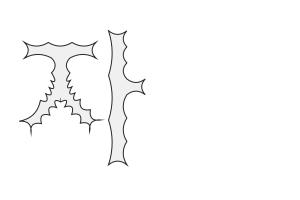

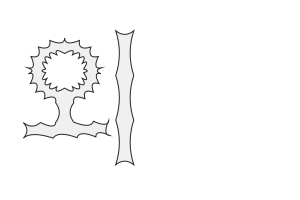

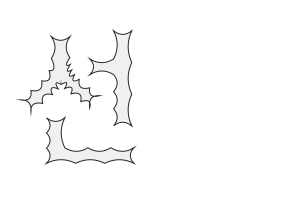

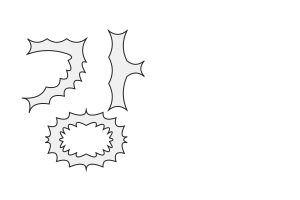

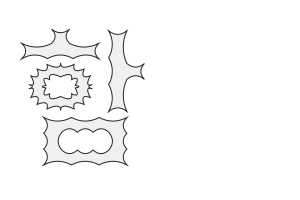

In [134]:
input_letters = ["자", "외", "선", "강", "함"]  
av = 50

for letter in input_letters:
    glyph_origin = glyphcommands(f, letter)    
    glyph_origin_direct = get_dir_list(glyph_origin)
    cutted_glyph = cut_glyph(["+right", "+left", "+up", "+down"], 3, glyph_origin, glyph_origin_direct)

    cutted_glyph_direct = get_dir_list(cutted_glyph)

    mod_glyph = make_design_glyph(cutted_glyph, cutted_glyph_direct, av)
    mod_path = Path(mod_glyph)
    
    page = document(300, 200, 'pt').addpage()
    pen = shape().stroke(rgb(40, 40, 40)).fill(rgb(240, 240, 240))
    page.place(pen.path(mod_path.scale(144/f.density).translate(20, 144)))
    
    show(page)